# **PRÁCTICA 2: PREDICCIÓN DEL ABANDONO (BURNOUT) DE EMPLEADOS**

**Aprendizaje Automatico Curso 2022/2023**

Grupo 10

*   Carmen Abans Maciel - 100432086@alumnos.uc3m.es
*   Noelia Hernandez Rodriguez - 100432116@alumnos.uc3m.es

## Librerias

In [972]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'svg'
%pip install missingno
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [973]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statistics
import time
import pickle

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.ticker as ticker
import missingno as msno
from scipy.stats import randint as sp_randint

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

## Cargar los datos

In [974]:
# Leer conjuntos de datos
with open('attrition_available_10.pkl', 'rb') as f:
    df = pickle.load(f)

In [975]:
# Cambiamos las opciones de respresentación para poder ver todos los valores
pd.options.display.max_columns = 31
pd.options.display.max_rows = 31

## Análisis Exploratorio de Datos

### Familiarización con los datos

In [976]:
# Mostrar las primeras 5 filas del DataFrame
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,4.0,3.0,2.0,NaN,31.0,Yes,Travel_Frequently,Research & Development,10.0,1.0,Life Sciences,1.0,2,Female,1.0,NaN,NaN,41890.0,NaN,Y,23.0,8.0,NaN,6.0,3.0,5.0,1,NaN
6,6.450877,17.0,NaN,4.0,1.0,NaN,1.0,28.0,Yes,Travel_Rarely,Research & Development,11.0,2.0,Medical,1.0,7,Male,NaN,Sales Executive,Single,58130.0,NaN,Y,20.0,8.0,1.0,5.0,2.0,0.0,0,0.0
13,8.871421,14.0,2.0,3.0,1.0,2.0,NaN,NaN,Yes,Non-Travel,Research & Development,1.0,1.0,Medical,1.0,14,Male,1.0,NaN,Married,57620.0,1.0,NaN,11.0,8.0,2.0,10.0,4.0,NaN,9,NaN
28,10.713066,6.0,2.0,3.0,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,Research & Development,1.0,2.0,Medical,1.0,29,NaN,2.0,Research Scientist,Divorced,103330.0,3.0,Y,14.0,8.0,NaN,19.0,2.0,1.0,0,0.0
30,9.662808,NaN,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,Research & Development,4.0,3.0,Medical,1.0,31,NaN,3.0,Research Scientist,Divorced,68540.0,2.0,Y,11.0,8.0,0.0,5.0,5.0,3.0,0,2.0


A primera vista podemos ver que nos encontramos con un conjunto de datos que tiene missing values, y variables tanto númericas como categóricas.

In [977]:
# Mostrar información sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3508 non-null   float64
 1   absences                 3594 non-null   float64
 2   JobInvolvement           3542 non-null   float64
 3   PerformanceRating        3706 non-null   float64
 4   EnvironmentSatisfaction  4385 non-null   float64
 5   JobSatisfaction          3494 non-null   float64
 6   WorkLifeBalance          3491 non-null   float64
 7   Age                      3491 non-null   float64
 8   Attrition                4410 non-null   object 
 9   BusinessTravel           4410 non-null   object 
 10  Department               3607 non-null   object 
 11  DistanceFromHome         3465 non-null   float64
 12  Education                3583 non-null   float64
 13  EducationField           3583 non-null   object 
 14  EmployeeCount           

Tras hacer la funcion info() podemos ver que tenemos 4410 filas y 31 columnas. Tenemos 23 atributos numéricos (21 floats64 + 2 int64), 1 ordinal (BusinessTravel) y 7 categoricos (Attrition, Department, EducationField, Gender, JobRole, MaritalStatus, Over18).

In [978]:
# Mostrar estadísticas descriptivas del DataFrame
df.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3508.000000,3594.000000,3542.000000,3706.000000,4385.000000,3494.000000,3491.000000,3491.000000,3465.000000,3583.00000,3459.0,4410.000000,3689.000000,3671.000000,3659.000000,3622.000000,3633.0,3639.000000,3584.000000,3660.000000,3609.000000,4410.000000,3577.000000
mean,7.329813,12.787423,2.727555,3.151916,2.723603,2.734974,2.758522,36.901461,9.172583,2.91962,1.0,2205.500000,2.061263,64834.666303,2.675048,15.212866,8.0,0.783182,11.331194,2.810929,6.953727,2.187755,4.117417
std,1.341327,5.500692,0.709418,0.358988,1.092756,1.100268,0.701499,9.093058,8.135983,1.02166,0.0,1273.201673,1.098973,47104.765244,2.479805,3.648491,0.0,0.841464,7.808871,1.287479,6.067325,3.221699,3.579970
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.00000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.283700,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.00000,1.0,1103.250000,1.000000,28980.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.024977,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.00000,1.0,2205.500000,2.000000,48980.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.957644,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.00000,1.0,3307.750000,3.000000,83760.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.00000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


Al ver la media, el minimo, el máximo y la desviación tipica podemos determinar que hay algunas columnas constantes que no nos van a aportar información. Estas son: EmployeeCount (siempre es 1) y StandardHours (siempre es 8).

In [979]:
# Borramos las columnas que no nos interesan
df.drop(['EmployeeCount', 'StandardHours'], axis=1, inplace=True)

In [980]:
# Número de muestras por clase Attrition (nuestra variable objetivo)
df.Attrition.value_counts().sort_index()

No     3699
Yes     711
Name: Attrition, dtype: int64

### ¿Ante que tipo de problema estamos?

El objetivo de nuestro modelo es saber si es probable que un empleado abandone la empresa, que esta indicado en la columna Attrition. Como queremos predecir una categoría para la variable Attrition estamos ante un problema de clasificación. Al estudiar la variable objetivo podemos ver que estamos ante un problema extremadamente desbalanceado (5:1) en el que hay muchas más personas que han abandonado la empresa, contra los que no.

### Limpieza de datos

Antes hemos visto que en el DataFrame tenemos valores nulos (missing values), por tanto vamos a estudiarlos y tratarlos

In [981]:
# ¿Hay missing values?
df.isnull().any()

hrs                         True
absences                    True
JobInvolvement              True
PerformanceRating           True
EnvironmentSatisfaction     True
JobSatisfaction             True
WorkLifeBalance             True
Age                         True
Attrition                  False
BusinessTravel             False
Department                  True
DistanceFromHome            True
Education                   True
EducationField              True
EmployeeID                 False
Gender                      True
JobLevel                    True
JobRole                     True
MaritalStatus               True
MonthlyIncome               True
NumCompaniesWorked          True
Over18                      True
PercentSalaryHike           True
StockOptionLevel            True
TotalWorkingYears           True
TrainingTimesLastYear       True
YearsAtCompany              True
YearsSinceLastPromotion    False
YearsWithCurrManager        True
dtype: bool

In [982]:
# ¿Cuántos hay?
df.isnull().sum()

hrs                        902
absences                   816
JobInvolvement             868
PerformanceRating          704
EnvironmentSatisfaction     25
JobSatisfaction            916
WorkLifeBalance            919
Age                        919
Attrition                    0
BusinessTravel               0
Department                 803
DistanceFromHome           945
Education                  827
EducationField             827
EmployeeID                   0
Gender                     713
JobLevel                   721
JobRole                    766
MaritalStatus              859
MonthlyIncome              739
NumCompaniesWorked         751
Over18                     870
PercentSalaryHike          788
StockOptionLevel           771
TotalWorkingYears          826
TrainingTimesLastYear      750
YearsAtCompany             801
YearsSinceLastPromotion      0
YearsWithCurrManager       833
dtype: int64

In [983]:
# Calcular la proporción en % de valores nulos por columna
prop_missing = (df.isnull().mean())*100
print(prop_missing)

hrs                        20.453515
absences                   18.503401
JobInvolvement             19.682540
PerformanceRating          15.963719
EnvironmentSatisfaction     0.566893
JobSatisfaction            20.770975
WorkLifeBalance            20.839002
Age                        20.839002
Attrition                   0.000000
BusinessTravel              0.000000
Department                 18.208617
DistanceFromHome           21.428571
Education                  18.752834
EducationField             18.752834
EmployeeID                  0.000000
Gender                     16.167800
JobLevel                   16.349206
JobRole                    17.369615
MaritalStatus              19.478458
MonthlyIncome              16.757370
NumCompaniesWorked         17.029478
Over18                     19.727891
PercentSalaryHike          17.868481
StockOptionLevel           17.482993
TotalWorkingYears          18.730159
TrainingTimesLastYear      17.006803
YearsAtCompany             18.163265
Y

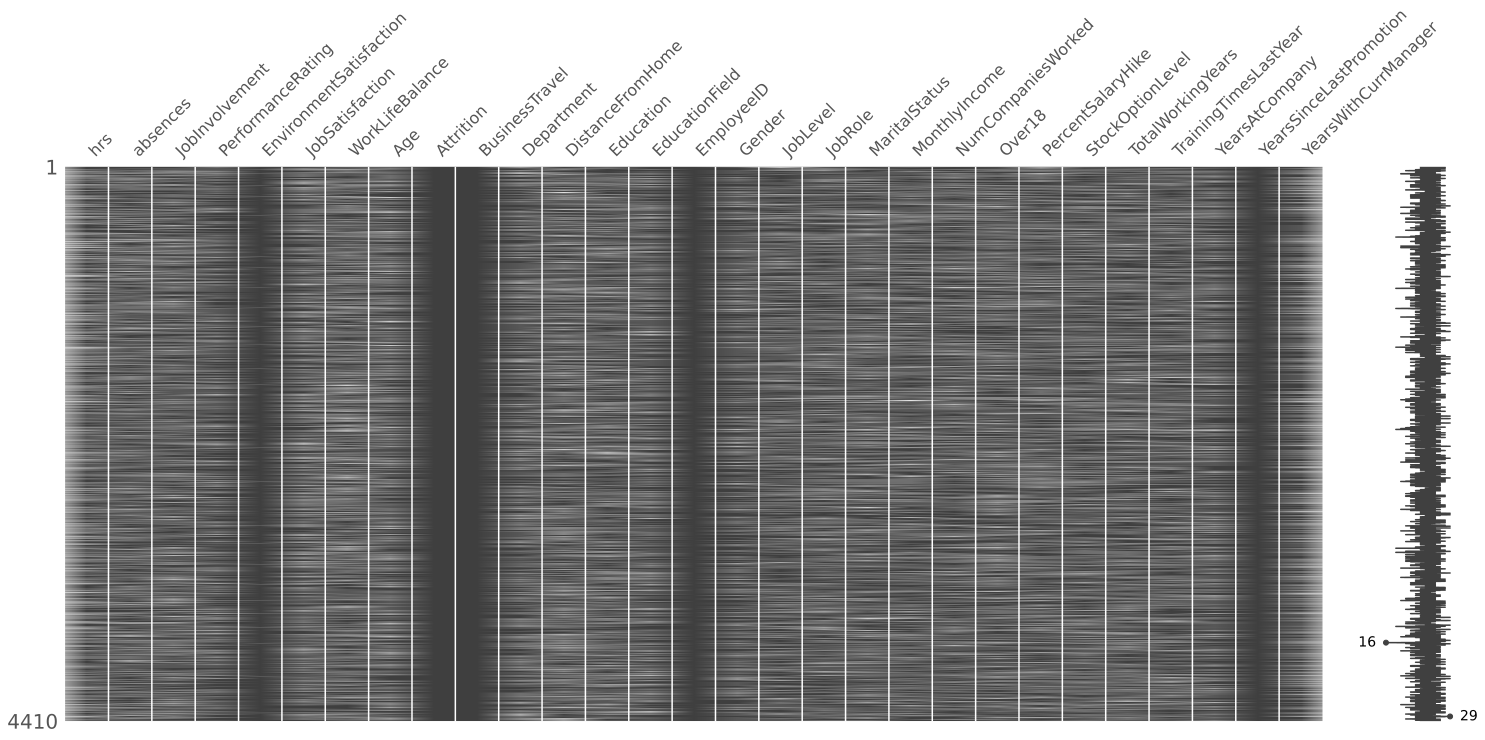

In [984]:
# Dibujar los valores nulos
msno.matrix(df)
plt.show()

Podemos ver que en el conjunto de datos hay una gran cantidad de valores nulos en casi todas las variables (menos Attrition, BusinessTravel, EmployeeID) en un rango del 0 al 20%, con una media del 15,37%.

Como EnvironmentSatisfaction tiene un porcentaje muy pequeño de missing values (0,57%) eliminamos las filas correspondientes

In [985]:
# Eliminar las filas con valores Nan en la columna 'EnvironmentSatisfaction'
df = df.dropna(subset=['EnvironmentSatisfaction'])

### Split de datos

Para hacer el tratamiento de los missing values vamos arealizar el split

In [986]:
# Nombrar variable x
x_df = df.drop('Attrition', axis=1)

# Nombrar variable y
y_df = df['Attrition']

# Dividir las muestras en entrenamiento y test con df
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_df, y_df, stratify=y_df, test_size=0.2, random_state=10, shuffle = True)

### Tratamiento de missing values

Para tratar los valores Nan en las variables categóricas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificamos con la técnica One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer las características más discriminantes.

Para los valores Nan en las variables numéricas vamos a realizar el siguiente proceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos el escalado

In [987]:
cat_cols = X_train_df.select_dtypes(include='object').columns
num_cols = X_train_df.select_dtypes(exclude='object').columns

# Variables categóricas
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

# Variables numéricas
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [988]:
# Preprocesado
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       '...
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])

## LogisticRegression

### Con los parametros por defecto

In [989]:
# Probamos el modelo sin aplicar ninguna regularización y con los parámetros por efecto
# ==============================================================================

# Creamos el pipeline con el modelo y el preprocesamiento de datos anterior
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(penalty='none', random_state = 10, class_weight='balanced'))])

np.random.seed(10) # Reproducibilidad

# Hacemos validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state = 10)
scores = cross_val_score(pipe_lr, X_train_df, y_train_df, scoring='balanced_accuracy', cv = cv)

# Imprimimos la precision
print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.2f} +- {scores.std():.2f}")

# Guardamos la media para su posterior comparación
lr_cv_a = scores.mean()

All the accuracies are: [0.71968804 0.68962035 0.70454545 0.68620904 0.65362323]
And the average crossvalidation accuracy is: 0.69 +- 0.02


In [990]:
np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
inicio_lr = time.time()
modelo = pipe_lr.fit(X=X_train_df, y=y_train_df)
fin_lr = time.time()

# Guardamos tiempo
run_time_lr = fin_lr-inicio_lr

# Predicciones
y_test_pred = modelo.predict(X_test_df)

# Classification report
lr_result = metrics.classification_report(y_test_df, y_test_pred)
print("Classification Report:",)
print (lr_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.66      0.77       736
         Yes       0.28      0.68      0.40       141

    accuracy                           0.67       877
   macro avg       0.60      0.67      0.58       877
weighted avg       0.81      0.67      0.71       877



In [991]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred)
lr_cm_a = metrics.accuracy_score(y_test_df, y_test_pred)
# Transform to df for easier plotting
lr_cm_df_result = pd.DataFrame(cm,
                     index = ['Yes','No'],
                     columns = ['Yes','No'])

print("Accuracy Score:",)
print (lr_cm_df_result)

Accuracy Score:
     Yes   No
Yes  489  247
No    45   96


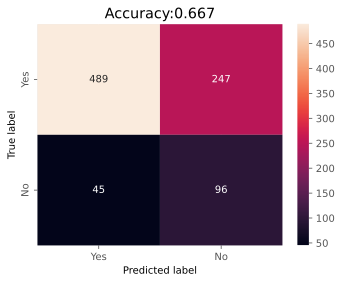

In [992]:
# La imprimimos de forma visual
plt.figure(figsize=(5.5,4))
sns.heatmap(lr_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(lr_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 489 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 277 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 45 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 96 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (489+96)/(489+247+45+96) = 66,7%,


In [993]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo.predict_proba(X_test_df)[:, 1]

lr_auc = metrics.roc_auc_score(y_test_df, probs)

y_test_df_t = np.where(y_test_df == 'Yes', 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)

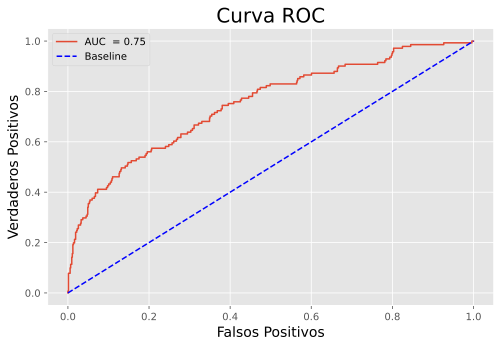

In [994]:
# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {lr_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido una curva de ROC con un AUC de 0,75. 
En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es buena.

### Ajuste de hiperparámetros
Los parámetros más importantes de la implantación de sklearn (`LogisticRegression`) son:

- `penalty`: El tipo de aplicación de regularización. Sus valores pueden ser:{None, 'l2' (por defecto), 'l1', 'elascticnet'}
- `C`: (por defecto 1.0) Inverso de la fuerza de regularización; Valores más pequeños especifican una regularización más fuerte.
- `solver`: Algoritmo a utilizar en el problema de optimización. Sus valores pueden ser: {‘lbfgs’ (por defecto), ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}.

In [995]:
# Busqueda de hiperparámetros
# ==============================================================================
param_distributions = [{'lr__penalty': ['l1', 'l2', 'elascticnet'],
                        'lr__C': np.arange(0.01, 3.01, 0.01).tolist(),
                        'lr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky','sag', 'saga']
                      }]

# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf = RandomizedSearchCV(pipe_lr,
                         param_distributions = param_distributions,
                         scoring='balanced_accuracy',
                         cv=5,
                         refit=True,
                         n_jobs=-1,
                         verbose=1,
                         return_train_score=True)

np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
clf.fit(X=X_train_df, y=y_train_df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeID', 'Jo...
                                                   0.11, 0.12, 0.13, 0.14,
                                                   0.15000000000000002, 0.16,
                                                   0.17, 0.18000000000000002,
                                                   0.19, 0.2,
                                                   0.21000000000000002, 0.22,
                                                   0.23, 0.24000000000000002,
                                                   0.25, 0.26, 0.27, 0.28,
                                                   0.29000000000000004, 0.3, ...],
                                         'lr__penalty': ['l1', 'l2',
                                                         'elascticnet'],
                                         'lr__solver': ['lbfgs', 'liblinear',
                                                        'newton-cg',
                                                        'newton-cholesky',
                                                        'sag', 'saga']}],
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [996]:
resultados = pd.DataFrame(clf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_lr__solver,param_lr__penalty,param_lr__C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,saga,l2,1.12,0.69134,0.021960,0.701213,0.002286
9,newton-cg,l2,1.14,0.69134,0.021960,0.701255,0.002263
7,newton-cg,l2,0.85,0.69117,0.022164,0.701213,0.002306
0,saga,l2,0.72,0.69117,0.022074,0.701255,0.002263
4,sag,l2,0.66,0.69117,0.022074,0.701298,0.002243


In [997]:
clf.best_params_, clf.best_score_

({'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__C': 1.12}, 0.691339595471285)

In [998]:
# Obtener los resultados
resultados = clf.cv_results_
scores = resultados['mean_test_score']

# Identificar los índices de los valores nan
nan_indices = np.isnan(scores)

# Filtrar los valores nan del array scores
scores_sin_nan = scores[~nan_indices]

# Calcular la media de los scores sin valores nan
lr_bh_cv_a = np.mean(scores_sin_nan)

# Imprimir la media de los scores
print("Media de balanced_accuracy (sin valores nan):", lr_bh_cv_a)

Media de balanced_accuracy (sin valores nan): 0.6909895279922061


In [999]:
# Información del modelo
# ==============================================================================
np.random.seed(10) # Reproducibilidad

# Cogemos el modelo entrenado con los mejores parametros 
modelo_final_lr = clf.best_estimator_

# Imprimimos info
print("Intercept:", modelo_final_lr['lr'].intercept_)
print("Coeficientes:", list(zip(df.columns, modelo_final_lr['lr'].coef_.flatten(), )))
print("Accuracy de test:", modelo_final_lr.score(X_test_df, y_test_df))

lr_bh_cv_a = modelo_final_lr.score(X_test_df, y_test_df)

Intercept: [-0.65064051]
Coeficientes: [('hrs', 0.6045540188537192), ('absences', 0.13901338844315486), ('JobInvolvement', -0.052400498405120004), ('PerformanceRating', 0.07063819452477894), ('EnvironmentSatisfaction', -0.6629676814331864), ('JobSatisfaction', -0.42274889514336206), ('WorkLifeBalance', -0.14922723202802587), ('Age', -0.4106539593616425), ('Attrition', 0.06281902836460664), ('BusinessTravel', -0.17452450738011133), ('Department', 0.07540141911133086), ('DistanceFromHome', -0.005436764716512701), ('Education', -0.1175494820387262), ('EducationField', 0.1516323545120365), ('EmployeeID', 0.04355524480207959), ('Gender', -0.04448361621729726), ('JobLevel', -0.29457072619405683), ('JobRole', -0.20396503084670678), ('MaritalStatus', 0.01522969108371089), ('MonthlyIncome', 0.3456828338031009), ('NumCompaniesWorked', -0.8339519800102654), ('Over18', -0.12509605283625205), ('PercentSalaryHike', 0.1932359706687614), ('StockOptionLevel', 0.3529448077144371), ('TotalWorkingYears', 

In [1000]:
np.random.seed(10) # Reproducibilidad

# Hacemos predicciones con test
y_test_pred = modelo_final_lr.predict(X_test_df)

# Classification report
lr_bh_result = metrics.classification_report(y_test_df, y_test_pred)
print("Classification Report:",)
print (lr_bh_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.66      0.77       736
         Yes       0.28      0.68      0.40       141

    accuracy                           0.67       877
   macro avg       0.60      0.67      0.58       877
weighted avg       0.81      0.67      0.71       877



In [1001]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred)
lr_bh_cm_a = metrics.accuracy_score(y_test_df, y_test_pred)
# Transform to df for easier plotting
lr_bh_cm_df_result = pd.DataFrame(cm,
                     index = ['Yes','No'],
                     columns = ['Yes','No'])

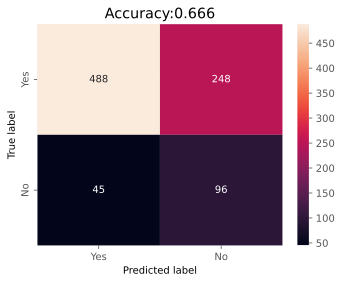

In [1002]:
# Confusion matrix
plt.figure(figsize=(5.5,4))
sns.heatmap(lr_bh_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(lr_bh_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 488 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 248 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 45 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 96 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (488+96)/(488+248+45+96) = 66.60%,

In [1003]:
# Convertir valores de y_test_df a 0 y 1
y_test_df_t = np.where(y_test_df == 'Yes', 1, 0)

#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo_final_lr.predict_proba(X_test_df)[:, 1]

lr_bh_auc = metrics.roc_auc_score(y_test_df, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)


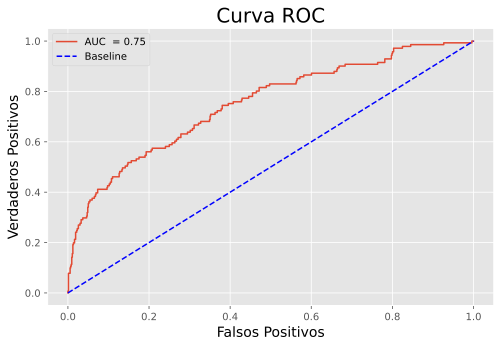

In [1004]:
# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {lr_bh_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido un AUC 0,75 con nuestra curva de ROC. En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es buena.

## Métodos avanzados

### HistGradientBoostingClassifier

##### Parámetros por defecto

In [1005]:
# Creación del modelo
# ==============================================================================
gb = HistGradientBoostingClassifier(random_state = 10, class_weight='balanced')

pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gb)
])

np.random.seed(10) # Reproducibilidad

# Entrenamiento del modelo con cv
# ==============================================================================
cv = KFold(n_splits=10, shuffle=True, random_state = 10)
scores = cross_val_score(pipeline_gb, X_train_df, y_train_df, scoring='balanced_accuracy', cv = cv)

# Imprimimos la precision
print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.2f} +- {scores.std():.2f}")
hgb_cv_a = scores.mean()

All the accuracies are: [0.82797203 0.80756014 0.76760913 0.77091915 0.81244556 0.76454694
 0.77299331 0.82674419 0.78214606 0.79934696]
And the average crossvalidation accuracy is: 0.79 +- 0.02


In [1006]:
np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
modelo = pipeline_gb.fit(X=X_train_df, y=y_train_df)

# Predicciones
y_test_pred = modelo.predict(X_test_df)
y_test_pred_t = np.where(y_test_pred == 'Yes', 1, 0) # Cambiamos formato

# Classification report
hgb_result = metrics.classification_report(y_test_df, y_test_pred)
print("Classification Report:",)
print (hgb_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95       736
         Yes       0.75      0.62      0.68       141

    accuracy                           0.91       877
   macro avg       0.84      0.79      0.81       877
weighted avg       0.90      0.91      0.90       877



In [1007]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred)
hgb_cm_a = metrics.accuracy_score(y_test_df, y_test_pred)
# Transform to df for easier plotting
hgb_cm_df_result = pd.DataFrame(cm,
                     index = ['Yes','No'],
                     columns = ['Yes','No'])


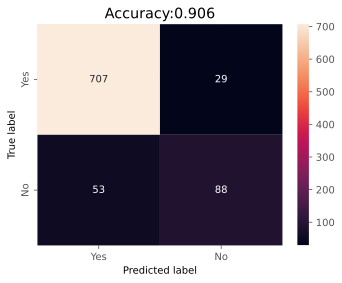

In [1008]:
# La imprimimos de forma visual
plt.figure(figsize=(5.5,4))
sns.heatmap(hgb_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(hgb_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 707 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 29 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 88 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 53 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (707+88)/(707+53+29+88) = 90.65%

In [1009]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo.predict_proba(X_test_df)[:, 1]

hgb_auc = metrics.roc_auc_score(y_test_df, probs)

y_test_df_t = np.where(y_test_df == 'Yes', 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)

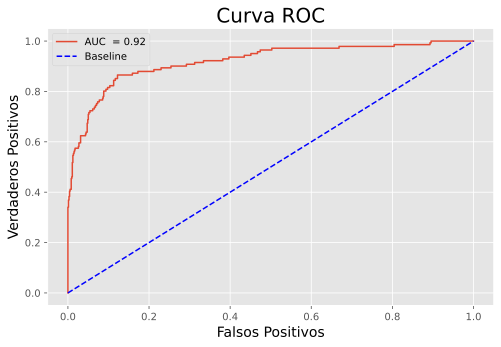

In [1010]:
# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {hgb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido un AUC 0,92 con nuestra curva de ROC. En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es excelente.

##### Busqueda parametros
Los parámetros más importantes de la implantación de sklearn (`HistGradientBoostingClassifier`) para controlar el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar *overfitting*, son:

- `learning_rate`: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- `max_iter`: El número máximo de iteraciones del proceso de boosting, es decir, el número máximo de árboles.
- `max_depth`: profundidad máxima que pueden alcanzar los árboles.
- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `validation_fraction`: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (*early stopping*).
- `n_iter_no_change`: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (*early stopping*). Si su valor es None se desactiva la parada temprana.
- `tol`: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.

In [1011]:
param_grid = {
    'class__learning_rate': np.arange(0.0001, 1, 0.001).tolist(),
    'class__max_iter': np.arange(1, 700, 100).tolist(),
    'class__max_depth': [None]+np.arange(1, 100, 5).tolist(),
    'class__min_samples_leaf': np.arange(1, 10, 1).tolist(),
    'class__max_leaf_nodes': [None]+np.arange(1, 50, 10).tolist(),
    'class__validation_fraction': np.arange(0.01, 1, 0.01).tolist(),
    'class__n_iter_no_change': [None]+np.arange(1, 10, 1).tolist(),
    'class__tol': np.arange(0.0001, 1, 0.0001).tolist(),
}

gb_clf = HistGradientBoostingClassifier(
    max_iter=1000,
    random_state=10,
    validation_fraction=0.1,
    n_iter_no_change=5,
    tol=0.0001,
    class_weight='balanced'
)

pipe_gb_ah = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('class', gb_clf)
])

# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
gb_classifier = RandomizedSearchCV(
    estimator=pipe_gb_ah,
    param_distributions=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=1,
    n_iter=5,
    return_train_score=True
)

np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
gb_classifier.fit(X=X_train_df, y=y_train_df)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeID', 'Jo...
                                        'class__validation_fraction': [0.01,
                                                                       0.02,
                                                                       0.03,
                                                                       0.04,
                                                                       0.05,
                                                                       0.060000000000000005,
                                                                       0.06999999999999999,
                                                                       0.08,
                                                                       0.09,
                                                                       0.09999999999999999,
                                                                       0.11,
                                                                       0.12,
                                                                       0.13,
                                                                       0.14,
                                                                       0.15000000000000002,
                                                                       0.16,
                                                                       0.17,
                                                                       0.18000000000000002,
                                                                       0.19,
                                                                       0.2,
                                                                       0.21000000000000002,
                                                                       0.22,
                                                                       0.23,
                                                                       0.24000000000000002,
                                                                       0.25,
                                                                       0.26,
                                                                       0.27,
                                                                       0.28,
                                                                       0.29000000000000004,
                                                                       0.3, ...]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [1012]:
resultados = pd.DataFrame(gb_classifier.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_class__validation_fraction,param_class__tol,param_class__n_iter_no_change,param_class__min_samples_leaf,param_class__max_leaf_nodes,param_class__max_iter,param_class__max_depth,param_class__learning_rate,mean_test_score,std_test_score,mean_train_score,std_train_score
3,0.65,0.4537,3,3,21,401,56,0.5571,0.769963,0.025771,1.0,0.0
0,0.19,0.9543,7,1,1,601,96,0.9651,NaN,NaN,NaN,NaN
1,0.76,0.9979,6,5,1,101,None,0.9691,NaN,NaN,NaN,NaN
2,0.84,0.6044,8,8,1,501,51,0.3981,NaN,NaN,NaN,NaN
4,0.51,0.1704,None,2,None,501,56,0.9781,NaN,NaN,NaN,NaN


In [1013]:
gb_classifier.best_params_, gb_classifier.best_score_

({'class__validation_fraction': 0.65,
  'class__tol': 0.4537,
  'class__n_iter_no_change': 3,
  'class__min_samples_leaf': 3,
  'class__max_leaf_nodes': 21,
  'class__max_iter': 401,
  'class__max_depth': 56,
  'class__learning_rate': 0.5571},
 0.7699634010191663)

In [1014]:
# Obtener los resultados
resultados = gb_classifier.cv_results_
scores = resultados['mean_test_score']

# Identificar los índices de los valores nan
nan_indices = np.isnan(scores)

# Filtrar los valores nan del array scores
scores_sin_nan = scores[~nan_indices]

# Calcular la media de los scores sin valores nan
hgb_bh_cv_a = np.mean(scores_sin_nan)

# Imprimir la media de los scores
print("Media de balanced_accuracy (sin valores nan):", hgb_bh_cv_a)

Media de balanced_accuracy (sin valores nan): 0.7699634010191663


In [1015]:
np.random.seed(10) # Reproducibilidad

modelo_final_gbh = gb_classifier.best_estimator_

# Hacemos predicciones con test
y_test_pred = modelo_final_gbh.predict(X_test_df)
y_test_pred_t = np.where(y_test_pred == 'Yes', 1, 0)

# Classification report
hgb_bh_result = metrics.classification_report(y_test_df, y_test_pred)
print("Classification Report:",)
print (hgb_bh_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.99      0.96       736
         Yes       0.92      0.57      0.70       141

    accuracy                           0.92       877
   macro avg       0.92      0.78      0.83       877
weighted avg       0.92      0.92      0.91       877



In [1016]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred)
hgb_bh_cm_a = metrics.accuracy_score(y_test_df, y_test_pred)
# Transform to df for easier plotting
hgb_bh_cm_df_result = pd.DataFrame(cm,
                     index = ['1','0'],
                     columns = ['Yes','No'])

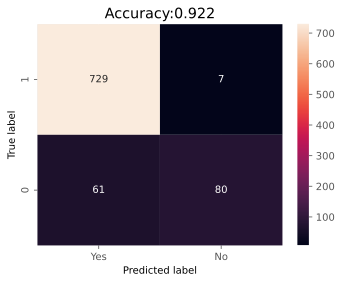

In [1017]:
plt.figure(figsize=(5.5,4))
sns.heatmap(hgb_bh_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(hgb_bh_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 729 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 7 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 80 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 61 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (729+80)/(729+80+61+7) = 92.25%,

In [1018]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo_final_gbh.predict_proba(X_test_df)[:, 1]

hgb_bh_auc = metrics.roc_auc_score(y_test_df_t, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)


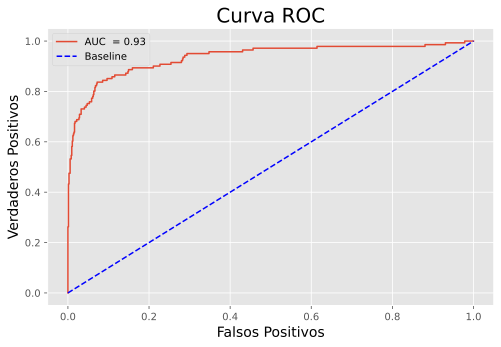

In [1019]:
# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {hgb_bh_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido un AUC 0,93 con nuestra curva de ROC. En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es excelente.

### XGBoost

#### Parametros por defecto

In [1020]:
# Creación del modelo y pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=10))
])

# Codificar las clases en valores numéricos
le = LabelEncoder()

np.random.seed(10) # Reproducibilidad

y_train_encoded = le.fit_transform(y_train_df)

# Entrenamiento del modelo
cv = KFold(n_splits=5, shuffle=True, random_state = 10)
scores = cross_val_score(pipe_lr, X_train_df, y_train_encoded, scoring='balanced_accuracy', cv = cv)

# Imprimimos la precision
print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.2f} +- {scores.std():.2f}")

# Guardamos la media para su posterior comparación
xgb_cv_a = scores.mean()


All the accuracies are: [0.71968804 0.68962035 0.70454545 0.68620904 0.65362323]
And the average crossvalidation accuracy is: 0.69 +- 0.02


In [1021]:
np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
modelo = pipeline_xgb.fit(X=X_train_df, y=y_train_encoded)

# Guardamos tiempo
y_test_pred = modelo.predict(X_test_df)
y_test_pred_t = np.where(y_test_pred == 1, 'Yes', 'No')

# Classification report
xgb_result = metrics.classification_report(y_test_df, y_test_pred_t)
print("Classification Report:",)
print (xgb_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.99      0.94       736
         Yes       0.88      0.46      0.60       141

    accuracy                           0.90       877
   macro avg       0.89      0.72      0.77       877
weighted avg       0.90      0.90      0.89       877



In [1022]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred_t)
xgb_cm_a = metrics.accuracy_score(y_test_df, y_test_pred_t)
# Transform to df for easier plotting
xgb_cm_df_result = pd.DataFrame(cm,
                     index = ['Yes','No'],
                     columns = ['Yes','No'])

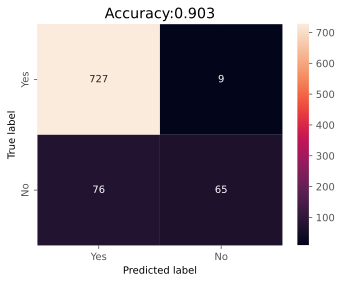

In [1023]:
# La imprimimos de forma visual
plt.figure(figsize=(5.5,4))
sns.heatmap(xgb_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(xgb_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 727 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 9 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 65 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 76 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (727+65)/(727+65+9+76) = 90.31%,

In [1024]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo.predict_proba(X_test_df)[:, 1]

xgb_auc = metrics.roc_auc_score(y_test_df, probs)

y_test_df_t = np.where(y_test_df == 'Yes', 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)

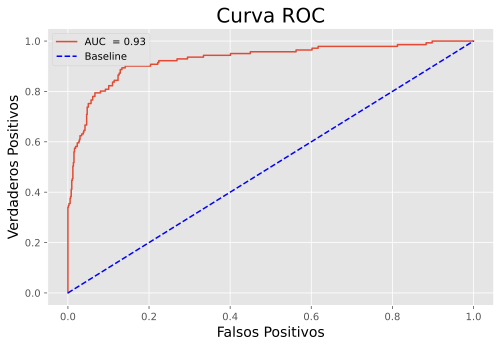

In [1025]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {xgb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido un AUC 0,93 con nuestra curva de ROC. En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es excelente.

#### Ajuste de hiperparámetros
Los parámetros más relevantes son:

- `n_estimators` (int) – Número de árboles usados. Equivalente al número de rondas de boosting.
- `learning_rate` (Optional[float]) – Indice de aprendizaje en el Boosting  (xgb’s “eta”). Es un valor de regularización/penalización para evitar sobreajuste, limitando la influencia de cada modelo en el conjunto del ensemble
- `booster` (Optional[str]) – Especifica el modelo a utilizar: gbtree, gblinear or dart.

In [1026]:
# Definir el diccionario de hiperparámetros para XGBClassifier
param_grid_xgb = {
    'classifier__n_estimators': np.arange(0, 800, 5).tolist(),
    'classifier__learning_rate': np.arange(0.001, 1, 0.0001).tolist(),
    'classifier__booster': ['gbtree', 'gblinear', 'dart'],
}

# Codificar las clases en valores numéricos
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train_df)

# Creación del modelo y pipeline
xgb_clf = XGBClassifier(random_state=10)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

# Realizar la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_grid_xgb,
    scoring='balanced_accuracy',
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=1,
    n_iter=5,
    return_train_score=True
)

np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
random_search.fit(X=X_train_df, y=y_train_encoded)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 2180, in balanced_accuracy_score
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeID', 'Jo...
                                                                      0.003200000000000001,
                                                                      0.003300000000000001,
                                                                      0.003400000000000001,
                                                                      0.0035000000000000014,
                                                                      0.003600000000000001,
                                                                      0.003700000000000001,
                                                                      0.0038000000000000013,
                                                                      0.0039000000000000016, ...],
                                        'classifier__n_estimators': [0, 5, 10,
                                                                     15, 20, 25,
                                                                     30, 35, 40,
                                                                     45, 50, 55,
                                                                     60, 65, 70,
                                                                     75, 80, 85,
                                                                     90, 95,
                                                                     100, 105,
                                                                     110, 115,
                                                                     120, 125,
                                                                     130, 135,
                                                                     140, 145, ...]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [1027]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(random_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_classifier__n_estimators,param_classifier__learning_rate,param_classifier__booster,mean_test_score,std_test_score,mean_train_score,std_train_score
4,80,0.5037,gbtree,0.710501,0.024984,1.000000,0.000000
2,615,0.035,dart,0.708590,0.026835,1.000000,0.000000
0,715,0.208,gblinear,0.567371,0.008614,0.571233,0.008428
3,605,0.2371,gblinear,0.567371,0.008614,0.571233,0.008428


In [1028]:
random_search.best_params_, random_search.best_score_

({'classifier__n_estimators': 80,
  'classifier__learning_rate': 0.5037000000000003,
  'classifier__booster': 'gbtree'},
 0.7105012975937253)

In [1029]:
# Obtener los resultados
resultados = random_search.cv_results_
scores = resultados['mean_test_score']

# Identificar los índices de los valores nan
nan_indices = np.isnan(scores)

# Filtrar los valores nan del array scores
scores_sin_nan = scores[~nan_indices]

# Calcular la media de los scores sin valores nan
xgb_bh_cv_a = np.mean(scores_sin_nan)

# Imprimir la media de los scores
print("Media de balanced_accuracy (sin valores nan):", xgb_bh_cv_a)


Media de balanced_accuracy (sin valores nan): 0.6384584784828184


In [1030]:
np.random.seed(10) # Reproducibilidad

# Cogemos el modelo entrenado con los mejores parametros 
modelo_final_xgb = random_search.best_estimator_

y_test_encoded = le.fit_transform(y_test_df)

# Hacemos predicciones con test
y_test_pred = modelo_final_xgb.predict(X_test_df)
y_test_pred_t = np.where(y_test_pred == 1, 'Yes', 'No')

# Classification report
xgb_bh_result = metrics.classification_report(y_test_df, y_test_pred_t)
print("Classification Report:",)
print (xgb_bh_result)

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.98      0.94       736
         Yes       0.85      0.48      0.61       141

    accuracy                           0.90       877
   macro avg       0.88      0.73      0.78       877
weighted avg       0.90      0.90      0.89       877



In [1031]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred_t)
xgb_bh_cm_a = metrics.accuracy_score(y_test_df, y_test_pred_t)
# Transform to df for easier plotting
xgb_bh_cm_df_result = pd.DataFrame(cm,
                     index = ['1','0'],
                     columns = ['Yes','No'])
print("Accuracy Score:")
print(xgb_bh_cm_df_result)

Accuracy Score:
   Yes  No
1  724  12
0   74  67


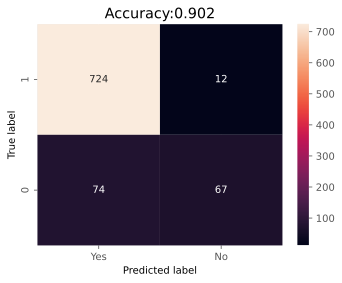

In [1032]:
plt.figure(figsize=(5.5,4))
sns.heatmap(xgb_bh_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(xgb_bh_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En la matriz de confusión se muestra el número de veces que el modelo ha clasificado correctamente (diagonal principal) y el número de veces que ha clasificado incorrectamente (diagonal secundaria) cada una de las clases. Hemos obtenido los siguientes datos:

- La clase "Yes" que hace referencia a la probabilidad de que los empleados si abandonen la empresa, ha sido clasificada correctamente 730 veces (verdaderos positivos) y ha sido clasificada incorrectamente como "No", probabilidad de que los empleados no abandonen la empresa en 6 ocasiones (falsos negativos).
- La clase "No" (probabilidad de que los empleados no abandonen la empresa) ha sido clasificada correctamente 63 veces (verdaderos negativos) y ha sido clasificada incorrectamente como "Yes" (probabilidad de los empleados si abandonen la empres) en 78 ocasiones (falsos positivos).

En resumen, este modelo ha logrado una precisión (accuracy) de (730+63)/(730+6+78+63) = 90.42%,

In [1033]:
# Encode labels using LabelEncoder
le = LabelEncoder()

np.random.seed(10) # Reproducibilidad

y_test_encoded = le.fit_transform(y_test_df)

# Get predicted probabilities and calculate ROC AUC score
probs = modelo_final_xgb.predict_proba(X_test_df)[:, 1]
xgb_bh_auc = roc_auc_score(y_test_encoded, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_encoded, probs)


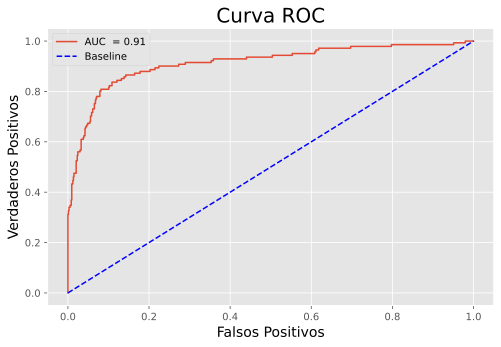

In [1034]:
# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {xgb_bh_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Hemos obtenido un AUC 0,94 con nuestra curva de ROC. En general, una curva ROC es considerada buena si el AUC es mayor o igual a 0,7 y excelente si el AUC es mayor o igual a 0,9. Sin embargo, esto puede variar dependiendo del contexto y del problema en cuestión. Por tanto, la curva de nuestro modelo es excelente.

## Comparación de modelos

In [1035]:
# Acurracy's + Curva ROC - AUC
# ==============================================================================

# Creamos un diccionario con los valores de cada columna
data = {
    'CV_accurray': [lr_cv_a, lr_bh_cv_a, hgb_cv_a, hgb_bh_cv_a, xgb_cv_a, xgb_bh_cv_a],
    #'Fit_acurracy': [],
    'CM_acurracy': [lr_cm_a, lr_bh_cm_a, hgb_cm_a, hgb_bh_cm_a, xgb_cm_a, xgb_bh_cm_a],
    'AUC de CurvaROC': [lr_auc, lr_bh_auc, hgb_auc, hgb_bh_auc, xgb_auc, xgb_bh_auc]
}

# Creamos un DataFrame a partir del diccionario
datos_df = pd.DataFrame(data, index=['LogisticRegression', 'LogisticRegression_bh', 'HistGradientBoosting', 'HistGradientBoosting_bh', 'XGBoost', 'XGBoost_bh'])

# Imprimimos el DataFrame
datos_df


,CV_accurray,CM_acurracy,AUC de CurvaROC
LogisticRegression,0.690737,0.667047,0.750511
LogisticRegression_bh,0.665906,0.665906,0.750472
HistGradientBoosting,0.793228,0.906499,0.919471
HistGradientBoosting_bh,0.769963,0.922463,0.934619
XGBoost,0.690737,0.903079,0.927517
XGBoost_bh,0.638458,0.901938,0.912774


Como podemos observar los mejores modelos son los de HistGradientBoosting para todas las metricas de la tabla. Pero nos llama la atencion que el acurracy del cross_validation y de la matriz sean tan diferentes tanto para histgradientboosting como para xgboost.

De momento vamos a ver si nos conviene elegir histgradientboosting con hiperparametros o por defecto con los valores del report.

In [1036]:
# Classification Reports
# ==============================================================================
print("Classification Report de LogisticRegression:",)
print (lr_result)
print("Classification Report de LogisticRegression_bh:",)
print (lr_bh_result)

Classification Report de LogisticRegression:
              precision    recall  f1-score   support

          No       0.92      0.66      0.77       736
         Yes       0.28      0.68      0.40       141

    accuracy                           0.67       877
   macro avg       0.60      0.67      0.58       877
weighted avg       0.81      0.67      0.71       877

Classification Report de LogisticRegression_bh:
              precision    recall  f1-score   support

          No       0.92      0.66      0.77       736
         Yes       0.28      0.68      0.40       141

    accuracy                           0.67       877
   macro avg       0.60      0.67      0.58       877
weighted avg       0.81      0.67      0.71       877



In [1037]:
print("Classification Report de HistGradientBoosting:",)
print (hgb_result)
print("Classification Report de HistGradientBoosting_bh:",)
print (hgb_bh_result)

Classification Report de HistGradientBoosting:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95       736
         Yes       0.75      0.62      0.68       141

    accuracy                           0.91       877
   macro avg       0.84      0.79      0.81       877
weighted avg       0.90      0.91      0.90       877

Classification Report de HistGradientBoosting_bh:
              precision    recall  f1-score   support

          No       0.92      0.99      0.96       736
         Yes       0.92      0.57      0.70       141

    accuracy                           0.92       877
   macro avg       0.92      0.78      0.83       877
weighted avg       0.92      0.92      0.91       877



In [1038]:
print("Classification Report de XGBoost:",)
print (xgb_result)
print("Classification Report de XGBoost_bh:",)
print (xgb_bh_result)

Classification Report de XGBoost:
              precision    recall  f1-score   support

          No       0.91      0.99      0.94       736
         Yes       0.88      0.46      0.60       141

    accuracy                           0.90       877
   macro avg       0.89      0.72      0.77       877
weighted avg       0.90      0.90      0.89       877

Classification Report de XGBoost_bh:
              precision    recall  f1-score   support

          No       0.91      0.98      0.94       736
         Yes       0.85      0.48      0.61       141

    accuracy                           0.90       877
   macro avg       0.88      0.73      0.78       877
weighted avg       0.90      0.90      0.89       877



Atendiendo a la métrica de classification report, nosotros creemos que para una empresa es mejor tener falsos positivos que falsos negativos. Por tanto atenderemos más al recall que a la precison, siendo f1 el balance entre estas dos. Buscamos principalmente que el modelo tenga un alto recall y un elevado valor de f1-score.

En logistic regresion da igual que modelo usar ya que tanto el de por defecto como el optimizado con hiperparametros tienen los mismos resultados (f1: 0.67, recall-no: 0.66). Por otro lado histgradient boosting un mejor resultado de f1 con el ajuste de hiperparametros de 0.01 y el recall es de 0.99 (no hay falsos negativos).

En xgboost el mejor modelo es el de por defecto con un f1-score 0.04 más, siendo que ambos tienen 0.99 recall negativo.

Por tanto volviendo a la cuestion de elegir que modelo es mejor, concluimos que como HistgradientBoosting es mejor con el ajuste de hiperparametros, este será nuestro modelo elejido para la evaluacion de caracteristicas y estudio de complejidad.


El mejor metodo es: HistGradientBoosting con ajuste de hiperparametros.

In [1039]:
# Entrenamos el modelo de nuevo
np.random.seed(10) # Reproducibilidad
modelo_final_elegido = gb_classifier.best_estimator_
y_test_pred = modelo_final_gbh.predict(x_df)

## Selección de atributos mediante métodos de filtrado

Veremos si podemos mejorar los resultados del aparato anterior y extraeremos conclusiones sobre qué atributos son más importantes, al menos de acuerdo a estos métodos

#### Selección de Atributos

In [1040]:
# Crear el selector de atributos
selector = SelectKBest(score_func=f_classif, k=5)

# Crear el pipeline con preprocesador y selector de características
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector)
])
np.random.seed(10) # Reproducibilidad
# Aplicar el pipeline a los datos de entrenamiento
X_train_selected = pipeline.fit_transform(X_train_df, y_train_df)

# Obtener los índices de los atributos seleccionados
selected_feature_indices = selector.get_support(indices=True)

# Obtener los nombres de los atributos seleccionados
selected_features = X_train_df.columns[selected_feature_indices]

print("Atributos seleccionados:", selected_features)

print(len(selected_features))

Atributos seleccionados: Index(['hrs', 'Age', 'JobRole', 'MonthlyIncome', 'Over18'], dtype='object')
5


#### Basados en la varianza

In [1041]:
pipe_sel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sel', VarianceThreshold(threshold=0.01))])

np.random.seed(10) # Reproducibilidad
sel = pipe_sel.fit(X=X_train_df, y=y_train_df)
sel_index = sel.named_steps['sel'].get_support()

# Asegurar que el índice booleano tenga la misma longitud que la cantidad de columnas en df_f
if len(sel_index) < x_df.shape[1]:
    sel_index = np.append(sel_index, [False] * (x_df.shape[1] - len(sel_index)))

# Seleccionar las columnas correspondientes en x_df
df_vt = x_df.iloc[:, sel_index]
print(df_vt.columns)

len(df_vt.columns)

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany'],
      dtype='object')


26

#### Mutual info
Calcula el valor de información mutua de cada una de las variables independientes con respecto a la variable dependiente y selecciona las que tienen mayor ganancia de información (al estilo de la ganancia de información de los árboles de decisión). En otras palabras, básicamente mide la dependencia de las características con el valor objetivo. Cuanto mayor sea la puntuación, mayor será la dependencia.

In [1042]:
threshold = 26  # Número de características más relevantes (la mitad)
np.random.seed(10) # Reproducibilidad

# Preprocesar los datos
X_preprocessed = preprocessor.fit_transform(x_df)

# Calcular las puntuaciones de información mutua
feature_scores = mutual_info_classif(X_preprocessed, y_df, random_state=10)

high_score_features = []
for score, f_name in sorted(zip(feature_scores, x_df.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
df_mic = x_df[high_score_features]
print(df_mic.columns)
print(len(df_mic.columns))

EducationField 0.11890017974683142
TotalWorkingYears 0.0726060341562702
YearsAtCompany 0.06623520955760664
TrainingTimesLastYear 0.06010600359999141
PercentSalaryHike 0.05961662085697861
StockOptionLevel 0.056915029415500085
JobRole 0.028764763148266814
Age 0.025544643578352177
hrs 0.024489747511304616
Over18 0.02415406935926523
Gender 0.012478143075828285
MonthlyIncome 0.012023138399322342
absences 0.009565359244942728
Department 0.007585610868292125
EnvironmentSatisfaction 0.006410615550493937
DistanceFromHome 0.00608625278757402
PerformanceRating 0.005745520179931685
NumCompaniesWorked 0.0049670134552579626
JobInvolvement 0.0034766471514444675
JobSatisfaction 0.003453996642628576
BusinessTravel 0.0029805888174299078
EmployeeID 0.0013817623764562637
JobLevel 0.0002636460195424295
MaritalStatus 6.491068328595695e-05
WorkLifeBalance 0.0
Education 0.0
Index(['EducationField', 'TotalWorkingYears', 'YearsAtCompany',
       'TrainingTimesLastYear', 'PercentSalaryHike', 'StockOptionLevel',


In [1043]:
# Primero debemos hacer el preprocesador que utilice solo estas variables seleccionadas

# Dividir las muestras en entrenamiento y test con df
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df_mic, y_df, stratify=y_df, test_size=0.2, random_state=10, shuffle = True)

# Obtener las columnas categóricas y numéricas
cat_cols = X_train_df.select_dtypes(include='object').columns
num_cols = X_train_df.select_dtypes(exclude='object').columns

# Variables categóricas
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=5))
])

# Variables numéricas
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['TotalWorkingYears', 'YearsAtCompany', 'TrainingTimesLastYear',
       'PercentSalaryHike', 'StockOptionLevel', 'Age', 'hrs', 'MonthlyIncome',
       'absences', 'EnvironmentSatisfaction', 'DistanceFromHome',
       'PerformanceRating', 'NumCompaniesWorked', 'JobInvolv...
       'JobSatisfaction', 'EmployeeID', 'JobLevel', 'WorkLifeBalance',
       'Education'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['EducationField', 'JobRole', 'Over18', 'Gender', 'Department',
       'BusinessTravel', 'MaritalStatus'],
      dtype='object'))])

In [1044]:
param_grid = {
    'class__learning_rate': np.arange(0.0001, 1, 0.001).tolist(),
    'class__max_iter': np.arange(1, 700, 100).tolist(),
    'class__max_depth': [None]+np.arange(1, 100, 5).tolist(),
    'class__min_samples_leaf': np.arange(1, 10, 1).tolist(),
    'class__max_leaf_nodes': [None]+np.arange(1, 50, 10).tolist(),
    'class__validation_fraction': np.arange(0.01, 1, 0.01).tolist(),
    'class__n_iter_no_change': [None]+np.arange(1, 10, 1).tolist(),
    'class__tol': np.arange(0.0001, 1, 0.0001).tolist(),
}

gb_clf2 = HistGradientBoostingClassifier(
    max_iter=1000,
    random_state=10,
    validation_fraction=0.1,
    n_iter_no_change=5,
    tol=0.0001,
    class_weight='balanced'
)

pipe_gb_ah2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('class', gb_clf2)
])

# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
gb_classifier2 = RandomizedSearchCV(
    estimator=pipe_gb_ah2,
    param_distributions=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=1,
    n_iter=5,
    return_train_score=True
)

np.random.seed(10) # Reproducibilidad

# Ajustamos el modelo
gb_classifier2.fit(X=X_train_df, y=y_train_df)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/carmenabansmaciel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['TotalWorkingYears', 'YearsAtCompany', 'TrainingTimesLastYear',
       'PercentSalaryHike', 'StockOptionLevel', 'Age', 'hrs', 'MonthlyIncome',
       'absences', 'EnvironmentSatisfaction', 'Dis...
                                        'class__validation_fraction': [0.01,
                                                                       0.02,
                                                                       0.03,
                                                                       0.04,
                                                                       0.05,
                                                                       0.060000000000000005,
                                                                       0.06999999999999999,
                                                                       0.08,
                                                                       0.09,
                                                                       0.09999999999999999,
                                                                       0.11,
                                                                       0.12,
                                                                       0.13,
                                                                       0.14,
                                                                       0.15000000000000002,
                                                                       0.16,
                                                                       0.17,
                                                                       0.18000000000000002,
                                                                       0.19,
                                                                       0.2,
                                                                       0.21000000000000002,
                                                                       0.22,
                                                                       0.23,
                                                                       0.24000000000000002,
                                                                       0.25,
                                                                       0.26,
                                                                       0.27,
                                                                       0.28,
                                                                       0.29000000000000004,
                                                                       0.3, ...]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [1045]:
gb_classifier2.best_params_, gb_classifier2.best_score_

({'class__validation_fraction': 0.65,
  'class__tol': 0.4537,
  'class__n_iter_no_change': 3,
  'class__min_samples_leaf': 3,
  'class__max_leaf_nodes': 21,
  'class__max_iter': 401,
  'class__max_depth': 56,
  'class__learning_rate': 0.5571},
 0.7460698844497157)

In [1046]:
# Obtener los resultados
resultados = gb_classifier2.cv_results_
scores = resultados['mean_test_score']

# Identificar los índices de los valores nan
nan_indices = np.isnan(scores)

# Filtrar los valores nan del array scores
scores_sin_nan = scores[~nan_indices]

# Calcular la media de los scores sin valores nan
hgb_bh_cv_a2 = np.mean(scores_sin_nan)

# Imprimir la media de los scores
print("Media de balanced_accuracy (sin valores nan):", hgb_bh_cv_a2)

Media de balanced_accuracy (sin valores nan): 0.7460698844497157


In [1047]:
np.random.seed(10) # Reproducibilidad

modelo_final_gbh = gb_classifier2.best_estimator_

# Hacemos predicciones con test
y_test_pred = modelo_final_gbh.predict(X_test_df)
y_test_pred_t = np.where(y_test_pred == 'Yes', 1, 0)

# Classification report
hgb_bh_result2 = metrics.classification_report(y_test_df, y_test_pred)
print("Classification Report:",)
print (hgb_bh_result2)

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.99      0.95       736
         Yes       0.88      0.51      0.65       141

    accuracy                           0.91       877
   macro avg       0.90      0.75      0.80       877
weighted avg       0.91      0.91      0.90       877



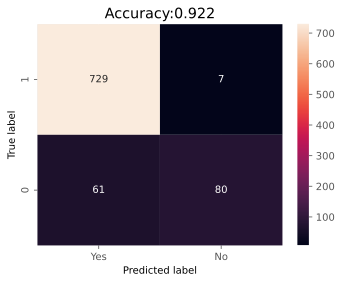

In [1048]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_df, y_test_pred)
hgb_bh_cm_a2 = metrics.accuracy_score(y_test_df, y_test_pred)
# Transform to df for easier plotting
hgb_bh_cm_df_result2 = pd.DataFrame(cm,
                     index = ['1','0'],
                     columns = ['Yes','No'])

plt.figure(figsize=(5.5,4))
sns.heatmap(hgb_bh_cm_df_result, annot=True, fmt=".0f")
plt.title('Accuracy:{0:.3f}'.format(hgb_bh_cm_a))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

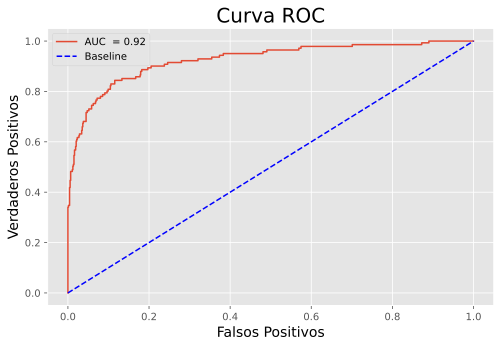

In [1049]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = modelo_final_gbh.predict_proba(X_test_df)[:, 1]

hgb_bh_auc2 = metrics.roc_auc_score(y_test_df_t, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_df_t, probs)

# Curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {hgb_bh_auc2:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

También podemos seleccionar, por ejemplo, aquellas variable cuya IM sea mayor que un valor (por ejemplo 0.2). Además, como ejemplo, voy a buscar el mejor clasificador usando sólo las variables seleccionadas. Esto mismo lo podemos hacer con el resto de métodos Filter.

In [1050]:
mi_score_selected_index = np.where(feature_scores > 0.01)[0]
df_mic2 = df.iloc[:,mi_score_selected_index]
np.random.seed(10) # Reproducibilidad
X_train2,X_test2,y_train,y_test = train_test_split(df_mic2,y_df,test_size=0.33, 
                                                     random_state=10, 
                                                     shuffle = True)

#### Comparacion con el modelo complejo

In [1051]:
print('Los valores cross-validation de hist_original y de hist_mutual_info:')
print(hgb_bh_cv_a, '|', hgb_bh_cv_a2)
print()
print('Los valores confussion marix de hist_original y de hist_mutual_info:')
print(hgb_bh_cm_a, '|', hgb_bh_cm_a2)
print()
print('Los valores auc de hist_original y de hist_mutual_info:')
print(hgb_bh_auc, '|', hgb_bh_auc2)
print()
print("Classification Report de HistGradientBoostingBH-original:",)
print (hgb_bh_result)
print("Classification Report de HistGradientBoosting_bh con mutual info:",)
print (hgb_bh_result2)

Los valores cross-validation de hist_original y de hist_mutual_info:
0.7699634010191663 | 0.7460698844497157

Los valores confussion marix de hist_original y de hist_mutual_info:
0.9224629418472063 | 0.9099201824401368

Los valores auc de hist_original y de hist_mutual_info:
0.9346187943262412 | 0.924635753931545

Classification Report de HistGradientBoostingBH-original:
              precision    recall  f1-score   support

          No       0.92      0.99      0.96       736
         Yes       0.92      0.57      0.70       141

    accuracy                           0.92       877
   macro avg       0.92      0.78      0.83       877
weighted avg       0.92      0.92      0.91       877

Classification Report de HistGradientBoosting_bh con mutual info:
              precision    recall  f1-score   support

          No       0.91      0.99      0.95       736
         Yes       0.88      0.51      0.65       141

    accuracy                           0.91       877
   macro avg   

Podemos ver un leve empeoramiento del modelo con menos parametros pero es tan pequeña que nos compensa elegir el modelo tras la seleccion de variables ya que tiene menos complejidad. Ya que el accurracy sigue siendo mayor a 0.90 con un buen recall.

In [1052]:
# Guardamos el modelo un fichero pkl
pkl_filename = "modelo_final.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump (modelo_final_gbh, file)

## Conclusiones finales

En este proyecto hemos podido comprobar que hay una gran diferencia entre las metricas de acurracy utilizadas para un mismo modelo. Eso nos hace ver que para seleccionar un modelo hay que tener en cuenta varias variables y decidir en torno al tipo de problema a tratar. En nuestro caso estamos haciendo un modelo para una empresa que quiere saber si sus empleados van a abandonar su empresa o no en torno a unas variables de los empleados. 

En nuestra opinion lo más probable es que esta empresa quiera saberlo para preparar al equipo de recursos humanos para que vayan preparandose para una nueva contratacion y asi evitar mayores inconvenientes en el flujo de trabajo y productividad. Por tanto nosotras consideramos que para ellos es preferible tener además de un modelo con una buena precision, un modelo que evite dar falsos negativos. Un falso negativo implicaria que la empresa se lleva una sorpresa ingrata y veria afectado su trabajo. En cambio un falso positivo, a pesar de no ser bueno, es menos malo que el anterior, ya que el flujo de trabajo no se veria afectado por una falta de personal ya que no se iría.

En general el acurracy de la matriz de confusion y el auc de la curva ROC mejoran tras la busqueda de hiperparámetros. Tambien podemos ver que de los modelos hay una clara tendencia a dar mayor precision en la predicción de No que de Yes (si). Tambien podemos ver como el logistic regresion no se adapta igual de bien que los metodos avanzados. Esto se debe probablemente a que no hay una relación lineal entre las caracteristicas y la variable objetivo.